## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [19]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [20]:
# место для кода
m = pd.read_csv('Members.csv',delimiter=',',index_col='MemberID')
claims = pd.read_csv('Claims_Y1.csv',delimiter=',',index_col='MemberID')
days_2 = pd.read_csv('DaysInHospital_Y2.csv',delimiter=',',index_col='MemberID')

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [21]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})


In [49]:
days_2.describe()

,ClaimsTruncated,DaysInHospital
count,76037.000000,76037.000000
mean,0.052225,0.154780
std,0.222481,0.361697
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [50]:
m.describe()

,AgeAtFirstClaim
count,113000.000000
mean,38.446522
std,25.440341
min,-1.000000
25%,20.000000
50%,40.000000
75%,60.000000
max,80.000000


In [52]:
claims

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,0,8- 9 months,NEUMENT,0,MED,0
99829076,6721023.0,265273.0,91972.0,Y1,Rehabilitation,Office,162+,0,0- 1 month,TRAUMA,0,MED,0
54666321,9932074.0,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,0,0- 1 month,RESPR4,0,RAD,0
66951188,4699470.0,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,0,0- 1 month,ROAMI,0,RAD,0
78859054,9121540.0,523791.0,21579.0,Y1,Emergency,Urgent Care,22,1,6- 7 months,HEART2,0,SDS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98535515,7638907.0,559727.0,83829.0,Y1,Emergency,Urgent Care,44,0,7- 8 months,TRAUMA,0,EM,0
1344508,4107701.0,164823.0,78718.0,Y1,Laboratory,Independent Lab,17,0,NaN,CATAST,0,SCS,0
73820095,1256697.0,789572.0,821.0,Y1,Surgery,Office,35,0,5- 6 months,MSC2a3,1,MED,0


## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [23]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()
f_Charlson, f_LengthOfStay

(MemberID
 210         0
 3197        0
 3889        1
 4187        0
 9063        0
            ..
 99995554    0
 99996214    0
 99997485    0
 99997895    0
 99998627    1
 Name: CharlsonIndex, Length: 76038, dtype: int64,
 MemberID
 210         2
 3197        0
 3889        3
 4187        0
 9063        0
            ..
 99995554    0
 99996214    0
 99997485    0
 99997895    0
 99998627    2
 Name: LengthOfStay, Length: 76038, dtype: int64)

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [40]:
data = days_2
data = data.join(f_Charlson)
data = data.join(f_LengthOfStay)
data = data.join(m['AgeAtFirstClaim'])

# место для кода
data.head(5)

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,,
98324177,0,0,0,0,30
33899367,1,1,0,0,80
5481382,0,1,0,0,20
69908334,0,0,0,0,60
29951458,0,0,0,0,40


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [41]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

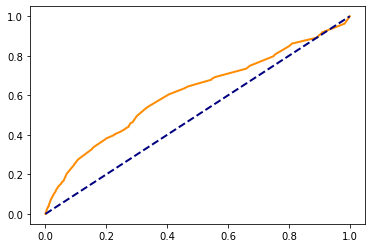

0.6125102736880302


In [42]:
res = calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [ ]:
def insert_and_one_hote_encode_column():
    pass

In [61]:
data_new = data 
data_new = data_new.join(pd.get_dummies(m.Sex,prefix = 'pol'))
data_new

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,pol_F,pol_M,pol_N
MemberID,,,,,,,,
98324177,0,0,0,0,30,0,1,0
33899367,1,1,0,0,80,1,0,0
5481382,0,1,0,0,20,1,0,0
69908334,0,0,0,0,60,1,0,0
29951458,0,0,0,0,40,0,1,0
...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,20,0,0,1
31530440,0,0,0,0,0,0,1,0
87102780,0,0,0,0,40,1,0,0


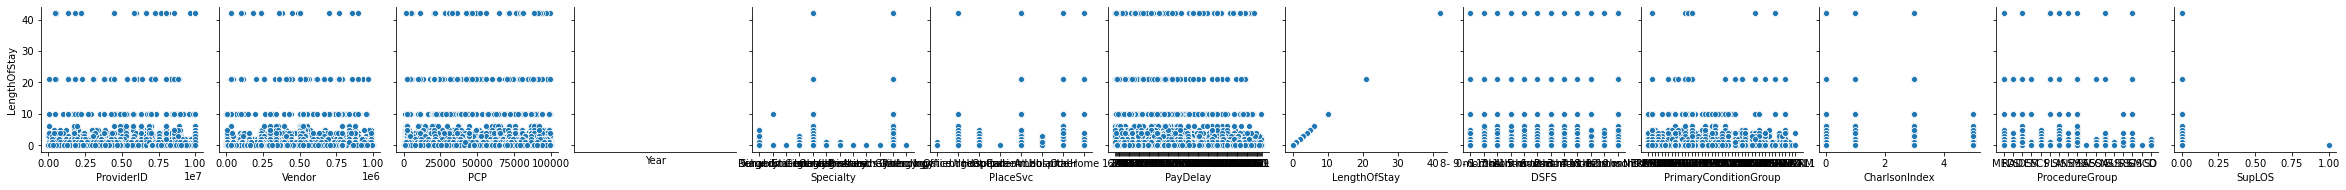

In [62]:
import seaborn as sns
sns.pairplot(
    claims,
    x_vars=['ProviderID','Vendor','PCP','Year','Specialty','PlaceSvc','PayDelay','LengthOfStay','DSFS',
            'PrimaryConditionGroup','CharlsonIndex','ProcedureGroup','SupLOS'],
    y_vars=["LengthOfStay"],
    height=2.5
)

## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [66]:
data_new = data_new.join(pd.get_dummies(claims.DSFS,prefix = 'dsfs'))
data_new = data_new.join(pd.get_dummies(claims.PrimaryConditionGroup,prefix = 'PCG'))
#data_new = data_new.join(pd.get_dummies(claims.ProcedureGroup,prefix = 'ProcG'))
#data_new = data_new.join(pd.get_dummies(claims.Specialty,prefix = 'Spcl'))


MemoryError: Unable to allocate 140. MiB for an array with shape (18328362,) and data type int64

Построившему матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством: +5 бонусных баллов.

c:\python 3.7.7\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


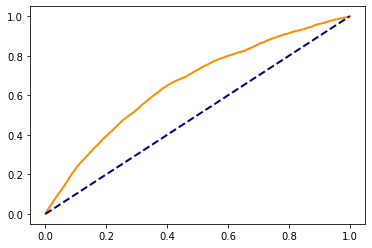

0.657653655626436


In [67]:
res_n = calcAUC(data_new)